
# 🧠 CLIP Benchmark on MSCOCO Test Split
*Presented by: R&D team*


This notebook evaluates OpenAI's CLIP (ViT-L/14) model on the COCO Karpathy test split (5K).

**Steps:**
1. Load the CLIP model and COCO dataset.
2. Encode all 5,000 validation images.
3. Perform text-to-image retrieval for 25,000 captions.
4. Compute Recall@1, Recall@5, and Recall@10 metrics.



🚀 Click on the link to open in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kamranjaved/Workshop-on-AI-and-Hand-on-training/blob/main/S6%3A%20CLIP%20inference%20tutorial%20/CLIP_MSCOCO_Benchmark.ipynb)


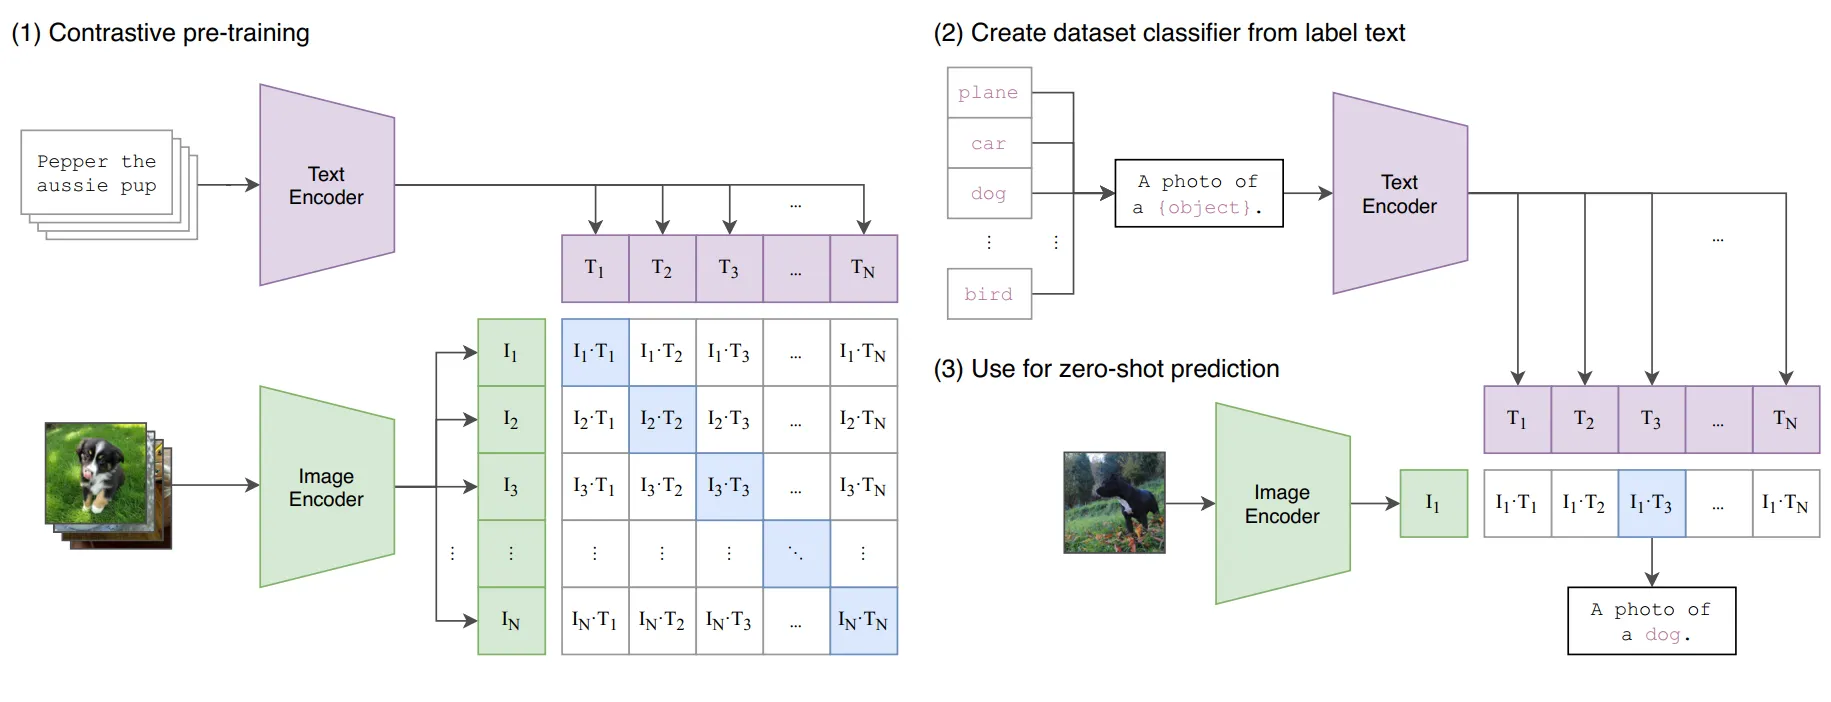

## 1. Setup and Imports

In [ ]:
!pip install git+https://github.com/openai/CLIP.git



In [ ]:
!pip install torch

In [ ]:

import os
import torch
import clip
from PIL import Image
from tqdm import tqdm
from datasets import load_dataset


## 2. Define Paths and Load CLIP Model

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)
model.eval()

print(f"Using device: {device}")


Using device: cuda


## 3. Load COCO Karpathy Dataset

In [20]:

#dataset = load_dataset("yerevann/coco-karpathy", split="test")
full_dataset = load_dataset("yerevann/coco-karpathy", split="test")

# Create a new dataset containing only the first 1000 examples
dataset = full_dataset.select(range(1000))

print(f"Loaded dataset with {len(dataset)} examples.")


Loaded dataset with 1000 examples.


## 4. Encode All Images

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shtvkumar/karpathy-splits")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'karpathy-splits' dataset.
Path to dataset files: /kaggle/input/karpathy-splits


In [13]:
!wget http://images.cocodataset.org/zips/val2014.zip


--2025-10-13 21:50:48--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.218.196, 54.231.196.241, 3.5.27.81, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.218.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  49.3MB/s    in 1m 56s  

2025-10-13 21:52:44 (54.5 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]



In [ ]:
!unzip val2014 -d coco_200

In [21]:
image_folder = "coco_200/val2014"
image_features = []
image_ids = []
caption_to_cocoid = {}

# Map each caption to its COCO image ID
for example in dataset:
    cocoid = example["cocoid"]
    for caption in example["sentences"]:
        caption_to_cocoid[caption] = cocoid

print("Encoding all 1K images...")
for example in tqdm(dataset):
    cocoid = example["cocoid"]
    image_path = os.path.join(image_folder, f"COCO_val2014_000000{cocoid:06d}.jpg")

    if not os.path.exists(image_path):
        continue

    try:
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model.encode_image(image)
            feat /= feat.norm(dim=-1, keepdim=True)
            image_features.append(feat.cpu())
            image_ids.append(cocoid)
    except Exception as e:
        print(f"Error with image {cocoid}: {e}")

image_features = torch.cat(image_features)
image_features = image_features.to(device)
print(f"✅ Encoded {len(image_features)} images.")


Encoding all 250 images...


100%|██████████| 1000/1000 [00:43<00:00, 23.13it/s]

✅ Encoded 1000 images.


## 5. Perform Caption-Based Image Retrieval

In [22]:

r1 = 0
r5 = 0
r10 = 0
total = 0

print("Running caption-based image retrieval (5K queries)...")
for example in tqdm(dataset):
    cocoid = example["cocoid"]
    for caption in example["sentences"]:
        prompt = f"A photo of {caption}"
        text_token = clip.tokenize([prompt]).to(device)

        with torch.no_grad():
            text_feat = model.encode_text(text_token)
            text_feat /= text_feat.norm(dim=-1, keepdim=True)

        sims = (text_feat @ image_features.T).squeeze(0)
        k = min(10, sims.size(-1))

        # Now run topk with the new k
        topk = sims.topk(k)
        #topk = sims.topk(10)
        top_image_ids = [image_ids[i] for i in topk.indices.tolist()]

        if cocoid == top_image_ids[0]:
            r1 += 1
        if cocoid in top_image_ids[:5]:
            r5 += 1
        if cocoid in top_image_ids[:10]:
            r10 += 1
        total += 1


Running caption-based image retrieval (25K queries)...


100%|██████████| 1000/1000 [01:10<00:00, 14.27it/s]


## 6. Report Final Results

In [23]:

print("\n===== 🧾 Final CLIP Benchmark Results on MSCOCO Test Split =====")
print(f"Total Queries (5 captions × 250 images): {total}")
print(f"Recall@1  = {r1/total:.2%}  ({r1}/{total})")
print(f"Recall@5  = {r5/total:.2%}  ({r5}/{total})")
print(f"Recall@10 = {r10/total:.2%}  ({r10}/{total})")



===== 🧾 Final CLIP Benchmark Results on MSCOCO Test Split =====
Total Queries (5 captions × 250 images): 5001
Recall@1  = 56.15%  (2808/5001)
Recall@5  = 83.14%  (4158/5001)
Recall@10 = 91.56%  (4579/5001)



## ✅ Summary
This notebook benchmarks the CLIP model on the MSCOCO test split.

**Results Interpretation:**
- **Recall@1**: % of times the correct image was ranked 1st for a caption.
- **Recall@5 / @10**: % of times the correct image appeared within the top 5 or 10 results.

Higher recall values indicate stronger image-text alignment.


**Thank You**

⭐ Feel free to star in the gothub ripo 🙏